### 加载mnist数据集

In [1]:
from keras.datasets import mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data() # 将下载好的mnist.npz方在 ~/.keras/datasets/ 目录下
print(x_train.shape,type(x_train))
print(y_train.shape,type(y_train))
print(x_test.shape,type(x_test))
print(y_test.shape,type(y_test))

D:\software\python\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(60000, 28, 28) <class 'numpy.ndarray'>
(60000,) <class 'numpy.ndarray'>
(10000, 28, 28) <class 'numpy.ndarray'>
(10000,) <class 'numpy.ndarray'>


### 数据处理：规范化

In [2]:
# 将图形从[28,28]变为[784,]
X_train = x_train.reshape(60000,784)
X_test = x_test.reshape(10000,784)
print(X_train.shape,X_test.shape)

(60000, 784) (10000, 784)


In [3]:
# 将数据转换为float32，为了进行归一化，不然/255得到全部是0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# 数据归一化
X_train /= 255
X_test /= 255

### 统计训练数据中个标签数量

In [4]:
import numpy as np
import matplotlib.pyplot as plt

label, count = np.unique(y_train, return_counts=True)
print(label, count)

[0 1 2 3 4 5 6 7 8 9] [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


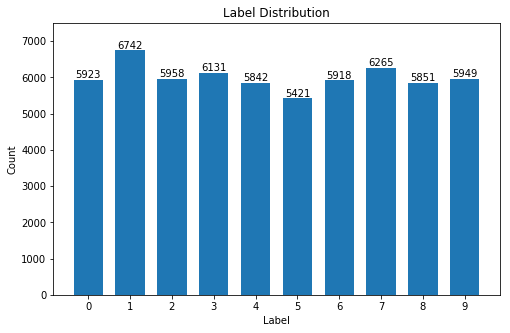

In [5]:
fig = plt.figure(figsize=(8, 5))
plt.bar(label, count, width=0.7, align='center')
plt.title("Label Distribution")
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(label)
plt.ylim(0, 7500)

for a, b in zip(label, count):
    plt.text(a, b, '%d' % b, ha='center', va='bottom', fontsize=10)

plt.show()

###  对标签进行one-hot编码

In [6]:
# import tensorflow as tf

# n_classes = 10
# Y_train = tf.one_hot(y_train, n_classes)
# Y_test = tf.one_hot(y_test, n_classes)

# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     Y_train=sess.run(Y_train)
#     Y_test=sess.run(Y_test)

# print(Y_train.shape)

# 下面代码同上，使用tensorflow需要建立会话，简单转换keras更方便
from keras.utils import np_utils

n_classes = 10
Y_train = np_utils.to_categorical(y_train,n_classes)
Y_test = np_utils.to_categorical(y_test,n_classes)

print(Y_train.shape)

(60000, 10)


In [7]:
print(y_train[0])
print(Y_train[0])

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 使用Keras sequential model 定义神经网络

In [9]:
# 使用keras定义线性网络很方便
from keras.models import Sequential
from keras.layers.core import Dense, Activation

model = Sequential()
# 第一隐藏层
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
# 第二隐藏层
model.add(Dense(512))
model.add(Activation('relu'))
# 输出层
model.add(Dense(10))
model.add(Activation('softmax'))

### 编译模型

In [11]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

### 训练模型，并将指标保存到history中

In [12]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=5,
                    verbose=2, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 7s - loss: 0.2156 - acc: 0.9373 - val_loss: 0.0970 - val_acc: 0.9710
Epoch 2/5
 - 7s - loss: 0.0804 - acc: 0.9758 - val_loss: 0.0769 - val_acc: 0.9770
Epoch 3/5
 - 7s - loss: 0.0504 - acc: 0.9838 - val_loss: 0.0791 - val_acc: 0.9746
Epoch 4/5
 - 7s - loss: 0.0350 - acc: 0.9891 - val_loss: 0.0659 - val_acc: 0.9804
Epoch 5/5
 - 8s - loss: 0.0264 - acc: 0.9913 - val_loss: 0.0734 - val_acc: 0.9794


### 可视化指标

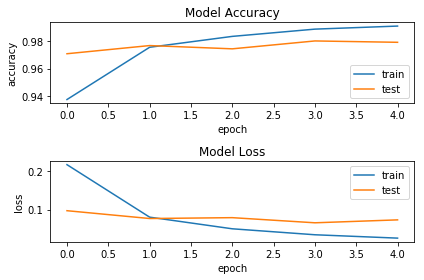

In [15]:
fig = plt.figure()
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.tight_layout()

plt.show()

### 保存模型

In [18]:
import os
import tensorflow.gfile as gfile

save_dir = '.\model'
if gfile.Exists(save_dir):
    gfile.DeleteRecursively(save_dir)
gfile.MakeDirs(save_dir)

model_name = 'keras_mnist.h5'
model_path = os.path.join(save_dir,model_name)
model.save(model_path)
print('Saved trained model at %s' % model_path)

Saved trained model at .\model\keras_mnist.h5


### 加载模型

In [19]:
from keras.models import load_model

mnist_model = load_model(model_path)

### 统计模型在测试集上的分类结果

In [24]:
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)
print("Test Loss: {}".format(loss_and_metrics[0]))
print("Test Accuracy: {}%".format(loss_and_metrics[1]*100))

predicted_classes = mnist_model.predict_classes(X_test)
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print("Classified correctly count: {}".format(len(correct_indices)))
print("Classified incorrectly count: {}".format(len(incorrect_indices)))

Test Loss: 0.07340353026344673
Test Accuracy: 97.94%
Classified correctly count: 9794
Classified incorrectly count: 206
